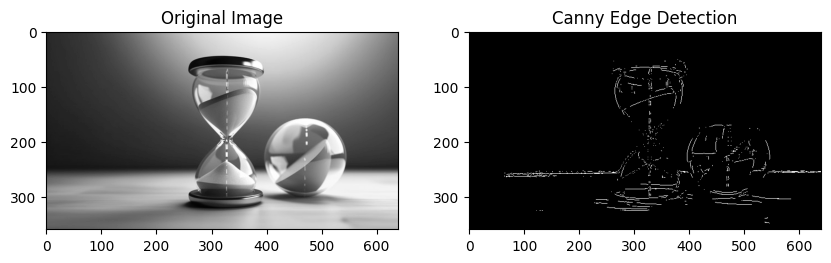

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert to grayscale
image = cv2.imread(r"image_path", cv2.IMREAD_GRAYSCALE)

# Step 1: Smoothing using Gaussian filter
smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Gradient calculation using Sobel operators
gradient_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude and angle of the gradients
magnitude = cv2.magnitude(gradient_x, gradient_y)
angle = cv2.phase(gradient_x, gradient_y, angleInDegrees=True)

# Step 3: Non-Maximum Suppression (thinning edges)
nms_image = np.zeros_like(magnitude)
for i in range(1, magnitude.shape[0] - 1):
    for j in range(1, magnitude.shape[1] - 1):
        # Get angle of the gradient
        ang = angle[i, j] % 180
        if (0 <= ang < 22.5) or (157.5 <= ang <= 180):
            neighbors = [magnitude[i, j+1], magnitude[i, j-1]]
        elif (22.5 <= ang < 67.5):
            neighbors = [magnitude[i+1, j-1], magnitude[i-1, j+1]]
        elif (67.5 <= ang < 112.5):
            neighbors = [magnitude[i+1, j], magnitude[i-1, j]]
        else:
            neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
        
        # Compare with neighbors and suppress non-maxima
        if magnitude[i, j] >= max(neighbors):
            nms_image[i, j] = magnitude[i, j]
        else:
            nms_image[i, j] = 0

# Step 4: Apply thresholding (Edge tracking by hysteresis)
low_threshold = 50
high_threshold = 150
edges = cv2.inRange(nms_image, low_threshold, high_threshold)

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Canny Edge Detection')
plt.imshow(edges, cmap='gray')
plt.show()


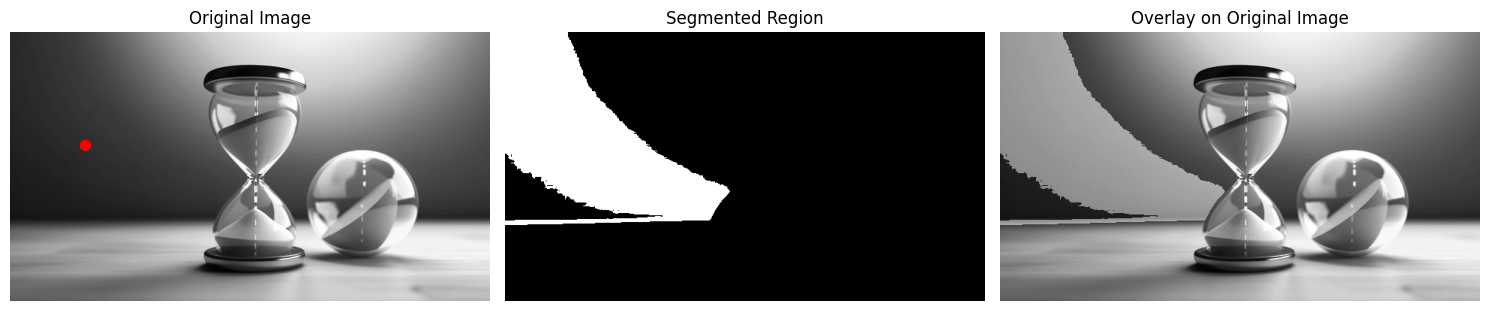

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed_point, threshold=10):
    """
    Perform region growing segmentation.

    Parameters:
    - image: Grayscale image for segmentation.
    - seed_point: Tuple (x, y) indicating the seed point.
    - threshold: Intensity similarity threshold.

    Returns:
    - segmented_image: Binary image with the segmented region.
    """
    height, width = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)
    visited = np.zeros((height, width), dtype=bool)

    # Seed point intensity
    seed_intensity = image[seed_point[1], seed_point[0]]
    # Stack for region growing (DFS approach)
    stack = [seed_point]

    while stack:
        x, y = stack.pop()
        if visited[y, x]:
            continue
        visited[y, x] = True

        # Include the point in the segmented region if within the threshold
        if abs(int(image[y, x]) - int(seed_intensity)) <= threshold:
            segmented_image[y, x] = 255

            # Check neighbors
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                    stack.append((nx, ny))

    return segmented_image

# Load and preprocess the image
image_path = r"image_path"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Select a seed point manually
seed_point = (100, 150)  # Example coordinates; change as needed

# Perform region growing
segmented_region = region_growing(image, seed_point, threshold=15)

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].scatter(*seed_point, color='red', s=50)  # Show the seed point
axs[0].axis('off')

# Segmented region
axs[1].imshow(segmented_region, cmap='gray')
axs[1].set_title("Segmented Region")
axs[1].axis('off')

# Overlay segmented region on original
overlay = cv2.addWeighted(image, 0.7, segmented_region, 0.3, 0)
axs[2].imshow(overlay, cmap='gray')
axs[2].set_title("Overlay on Original Image")
axs[2].axis('off')

plt.tight_layout()
plt.show()
